In [1]:
from cliff_game import CliffGame, Action
from algorithms import Sarsa

In [2]:
cg = CliffGame()
print(cg)

reward = 0



|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S* |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [3]:
r, game_over = cg.move(Action.UP)
reward += r
print(reward, game_over)
print(cg)

-1 False

|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|   * |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [4]:
seq = [Action.RIGHT, Action.RIGHT, Action.DOWN, Action.RIGHT]

for i, action in enumerate(seq):
    print(f"{i+1}/{len(seq)} Moving {action.name}")
    r, game_over = cg.move(action)
    reward += r
    if game_over:
        print("Game Over")
        break

print("\nTotal reward:", reward)
print(cg)

1/4 Moving RIGHT
2/4 Moving RIGHT
3/4 Moving DOWN
Game Over

Total reward: -103

|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|     |     |     |     |     |     |     |     |     |     |     |     |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|  S  |  C  |  C* |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  C  |  G  |
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|



In [5]:
sarsa = Sarsa(cg)
rewards = []
for i in range(100):
    cg.reset()
    _, _, r = sarsa.run()
    rewards.append(r)
    # print(" ", r)

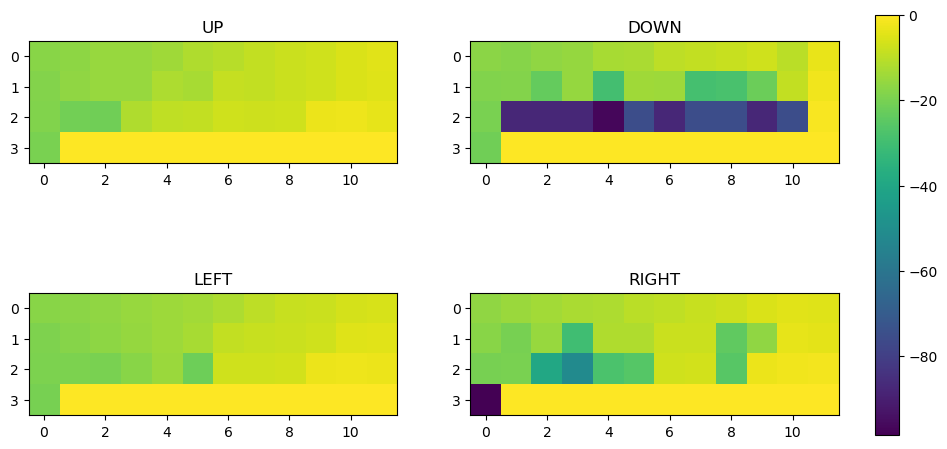

In [6]:
sarsa.plot_q_values()


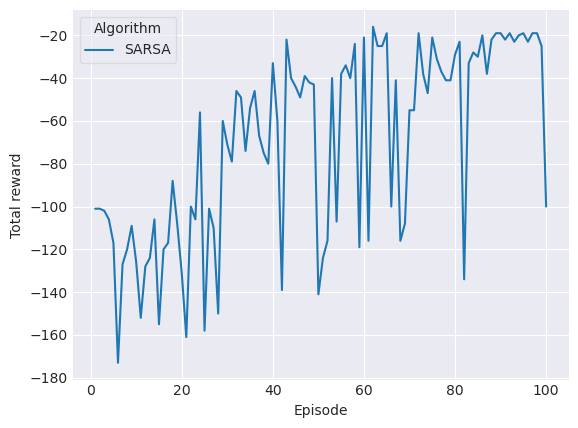

In [7]:
import matplotlib.pyplot as plt
import numpy as np

with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, ax  = plt.subplots()
    ax.plot(np.arange(len(rewards)) + 1, rewards, label="SARSA")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total reward")

    ax.legend(title="Algorithm", fancybox=True, framealpha=0.5, frameon=True)

In [8]:
cg.reset()
trajectory, actions, _ = sarsa.run(dry=True, verbose=True)
trajectory

+++++++++++++++++

[State(x=3, y=0),
 State(x=2, y=0),
 State(x=1, y=0),
 State(x=1, y=1),
 State(x=0, y=1),
 State(x=0, y=2),
 State(x=0, y=3),
 State(x=0, y=4),
 State(x=0, y=5),
 State(x=0, y=6),
 State(x=0, y=7),
 State(x=0, y=8),
 State(x=0, y=9),
 State(x=0, y=10),
 State(x=0, y=11),
 State(x=1, y=11),
 State(x=2, y=11),
 State(x=3, y=11)]

In [9]:
actions

[<Action.UP: 1>,
 <Action.UP: 1>,
 <Action.RIGHT: 4>,
 <Action.UP: 1>,
 <Action.RIGHT: 4>,
 <Action.RIGHT: 4>,
 <Action.RIGHT: 4>,
 <Action.RIGHT: 4>,
 <Action.RIGHT: 4>,
 <Action.RIGHT: 4>,
 <Action.RIGHT: 4>,
 <Action.RIGHT: 4>,
 <Action.RIGHT: 4>,
 <Action.RIGHT: 4>,
 <Action.DOWN: 2>,
 <Action.DOWN: 2>,
 <Action.DOWN: 2>]

In [10]:
y_coords, x_coords = list(zip(*trajectory))


In [12]:
_, policy_actions, _ = sarsa.get_current_policy()
policy_actions

array([[<Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.DOWN: 2>],
       [<Action.RIGHT: 4>, <Action.UP: 1>, <Action.UP: 1>,
        <Action.UP: 1>, <Action.RIGHT: 4>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.RIGHT: 4>, <Action.UP: 1>,
        <Action.LEFT: 3>, <Action.RIGHT: 4>, <Action.DOWN: 2>],
       [<Action.UP: 1>, <Action.LEFT: 3>, <Action.LEFT: 3>,
        <Action.UP: 1>, <Action.UP: 1>, <Action.UP: 1>, <Action.LEFT: 3>,
        <Action.RIGHT: 4>, <Action.LEFT: 3>, <Action.RIGHT: 4>,
        <Action.RIGHT: 4>, <Action.DOWN: 2>],
       [<Action.UP: 1>, '', '', '', '', '', '', '', '', '', '', '']],
      dtype=object)

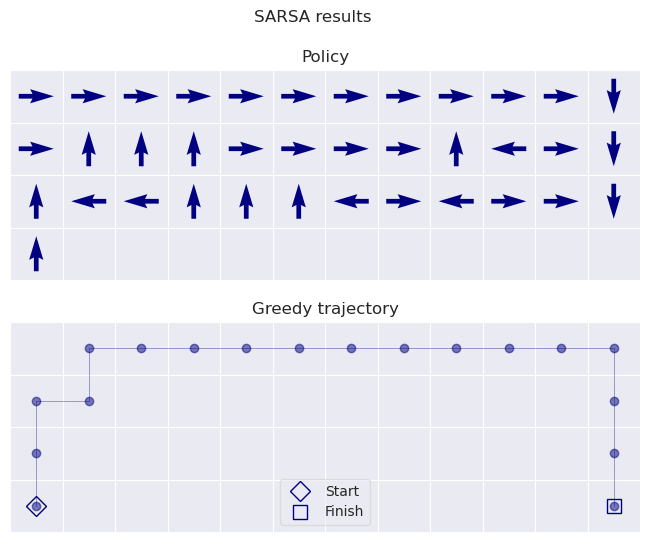

In [13]:
sarsa.plot_current_policy(trajectory)